In [1]:
import sys
sys.path.append(r'../')
import numpy as np
import mat73
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model 
from tensorflow.keras.losses import Loss
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

2022-08-17 17:01:33.503665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-17 17:01:33.503685: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class Database:

    def __init__(self):
        data_set_no = 0
        data_dict = mat73.loadmat('NoStim_Data.mat')
        data  = data_dict['NoStim_Data']

        deltaFOverF_bc = data['deltaFOverF_bc'][data_set_no]
        derivatives = data['derivs'][data_set_no]
        NeuronNames = data['NeuronNames'][data_set_no]
        fps = data['fps'][data_set_no]
        States = data['States'][data_set_no]


        self.states = np.sum([n*States[s] for n, s in enumerate(States)], axis = 0).astype(int) # making a single states array in which each number corresponds to a behaviour
        self.state_names = [*States.keys()]
        self.neuron_traces = np.array(deltaFOverF_bc).T
        self.derivative_traces = derivatives['traces'].T
        self.neuron_names = np.array(NeuronNames, dtype=object)
        self.fps = fps

In [3]:
data = Database()
X = data.neuron_traces.T
B = data.states

In [4]:
X.shape

(3137, 109)

In [5]:
X = X[:,:100]

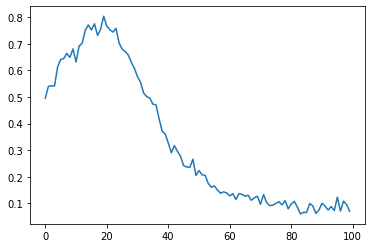

In [6]:
plt.plot(X[1500:1600,25])

([], [])

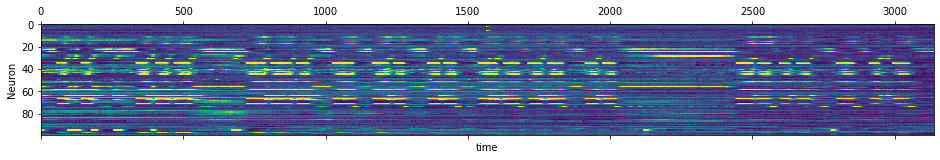

<Figure size 432x288 with 0 Axes>

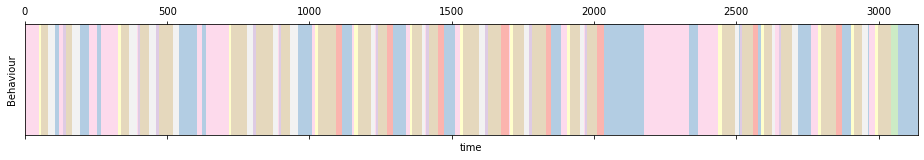

In [7]:
plt.matshow(X.T, aspect='auto', vmin=0, vmax=0.7)
plt.xlabel('time')
plt.ylabel('Neuron')
plt.figure()
plt.matshow([B], cmap="Pastel1", aspect="auto")
plt.xlabel('time')
plt.ylabel('Behaviour')
plt.yticks([])


In [8]:
# Preparing the data
gap=5
X_0, X_1 = X[:-gap], X[gap:]
B_1 = B[1:]
X_paired = np.array([X_0, X_1])
X_paired = np.transpose(X_paired, axes=(1,0,2))

# Train test split
X_train, B_train_1 = np.r_[X_paired[0:1000], X_paired[1500:]], np.r_[B_1[0:1000], B_1[1500:]]
X_test, B_test_1 = X_paired[1000:1500], B_1[1000:1500]

### Autoregressor model

In [9]:
X_diff_train = X_train[:,1,:] - X_train[:,0,:]
X_diff_test = X_test[:,1,:] - X_test[:,0,:]

Epoch 1/15


2022-08-17 17:01:36.113276: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-08-17 17:01:36.113299: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: akshey-System-Product-Name
2022-08-17 17:01:36.113303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: akshey-System-Product-Name
2022-08-17 17:01:36.113352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-08-17 17:01:36.113367: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-08-17 17:01:36.113372: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.129.6 does not match DSO version 470.141.3 -- cannot find working devices in this configuration
2022-08-17 17:01:36.113600: I tensorflow/core/platform/c

9/9 [==============================] - 0s 13ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 2/15
9/9 [==============================] - 0s 3ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 3/15
9/9 [==============================] - 0s 3ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 4/15
9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 5/15
9/9 [==============================] - 0s 3ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 6/15
9/9 [==============================] - 0s 3ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 7/15
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/15
9/9 [==============================] - 0s 3ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0029 - va

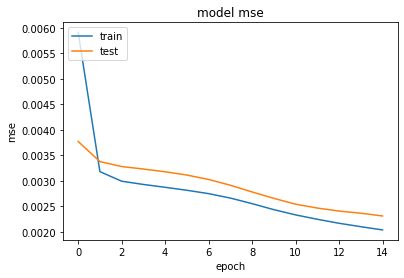

In [10]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='linear')
])

model_1.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

history = model_1.fit(X_train[:,0,:], 
                      X_diff_train, 
                      epochs=15,
                      batch_size=300,
                      validation_data=(X_test[:,0,:], X_diff_test),
)

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluation

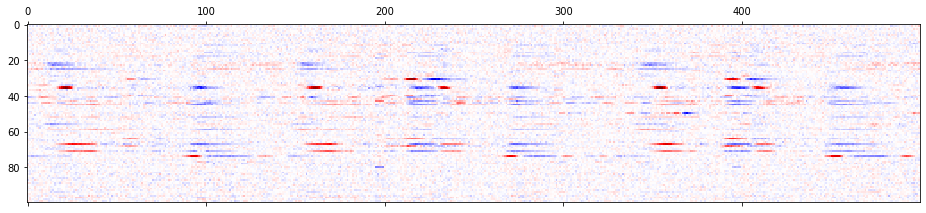

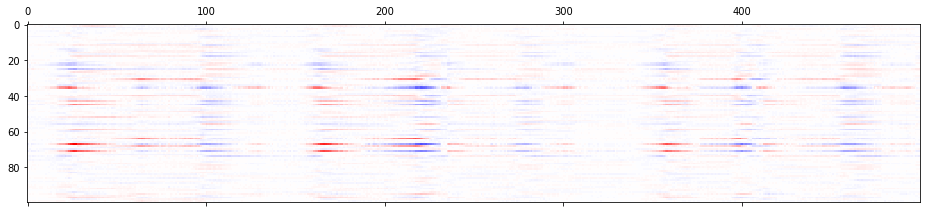

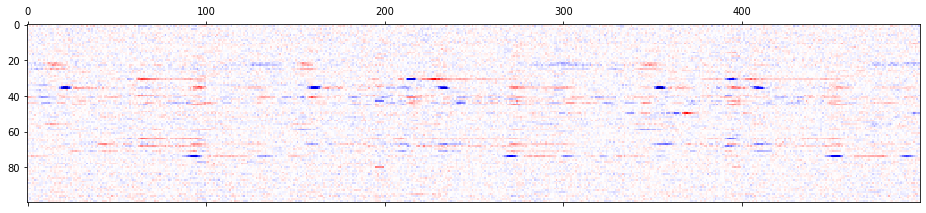

In [11]:
X_diff_pred = model_1(X_test[:,0,:]).numpy()
plt.matshow(X_diff_test.T, cmap="seismic", vmin=-1, vmax=1)
plt.matshow(X_diff_pred.T, cmap="seismic", vmin=-1, vmax=1)
plt.matshow(X_diff_pred.T- X_diff_test.T, cmap="seismic", vmin=-1, vmax=1)

In [12]:
def r2_single(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    return 1 - mse(y_pred, y_true)/tf.math.reduce_variance(y_true)

def r2(Y_true, Y_pred):
    r2_list=[]
    for i in range(Y_true.shape[-1]):
        R2 = r2_single(Y_true[:,i], Y_pred[:,i])
        r2_list.append(R2)
    r2_list = tf.stack(r2_list)
    return tf.math.reduce_mean(r2_list)

In [13]:
mse = tf.keras.losses.MeanSquaredError()
mse(X_diff_test, X_diff_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0023075978>

In [14]:
r2(X_diff_test, X_diff_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.006986991205946725>

# With several past time steps appended

In [15]:
# Preparing the data
win = 12
gap = 10
X_diff = X[win:] - X[win-gap:-gap]

In [16]:
X_win = np.zeros((X.shape[0]-win, win, X.shape[1]))

for i, _ in enumerate(X_win):
    X_win[i] = X[i:i+win]
    
# Train test split
Xwin_train, Xdiff_train  = np.r_[X_win[0:1000], X_win[1500:]], np.r_[X_diff[0:1000], X_diff[1500:]]
Xwin_test, Xdiff_test = X_win[1000:1500], X_diff[1000:1500]

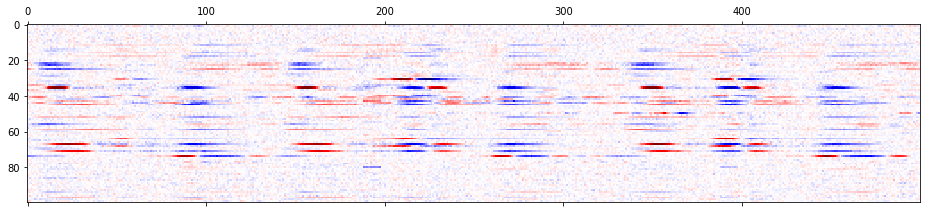

In [17]:
plt.matshow(Xdiff_test.T, cmap='seismic', vmin=-1, vmax=1)

In [18]:
model_2 = tf.keras.Sequential([
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Conv1D(filters=100,
                           kernel_size=(3,),
                           activation='relu', input_shape = (win,100,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='linear')
])
#model_2.build(input_shape = (50,100,))
model_2.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 100)           30100     
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               100100    
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 100)               5100      
                                                                 
Total params: 140,350
Trainable params: 140,350
Non-trainable params: 0
_________________________________________________________________


Epoch 1/45
53/53 [==============================] - 0s 3ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 2/45
53/53 [==============================] - 0s 2ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 3/45
53/53 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 4/45
53/53 [==============================] - 0s 2ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 5/45
53/53 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 6/45
53/53 [==============================] - 0s 2ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/45
53/53 [==============================] - 0s 2ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 8/45
53/53 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.00

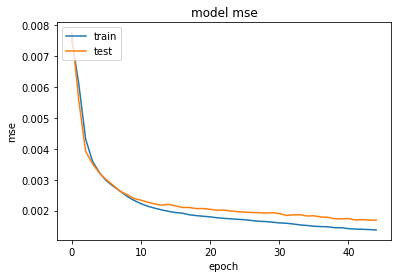

In [19]:
model_2.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

history = model_2.fit(Xwin_train,
                      Xdiff_train,
                      epochs=45,
                      batch_size=50,
                      validation_data=(Xwin_test, Xdiff_test)
                      )

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

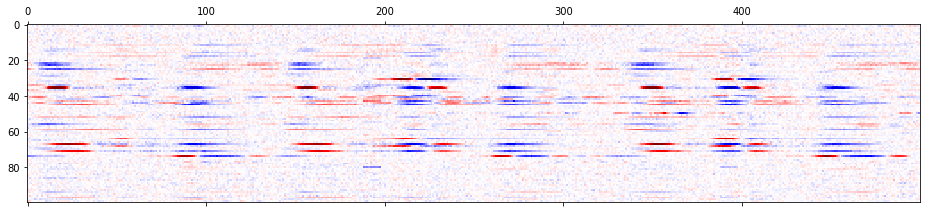

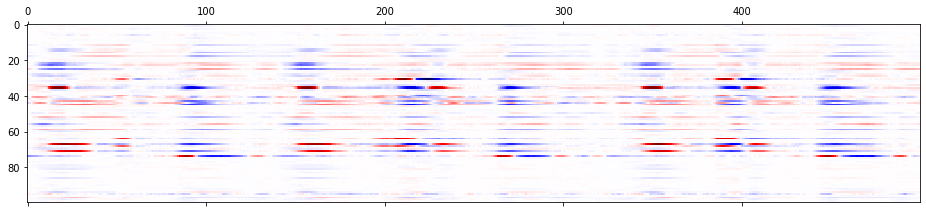

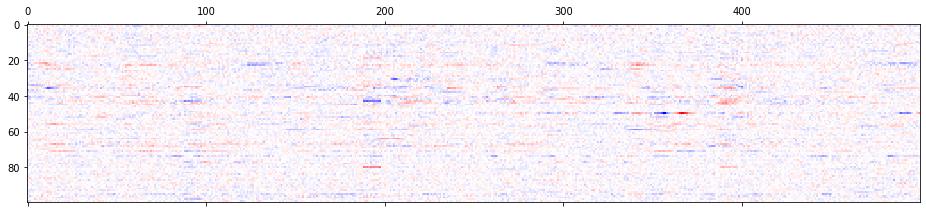

In [20]:
Xdiff_pred = model_2(Xwin_test).numpy()
plt.matshow(Xdiff_test.T, cmap="seismic", vmin=-1, vmax=1)
plt.matshow(Xdiff_pred.T, cmap="seismic", vmin=-1, vmax=1)
plt.matshow(Xdiff_pred.T- Xdiff_test.T, cmap="seismic", vmin=-1, vmax=1)

In [21]:
mse = tf.keras.losses.MeanSquaredError()
print('Mean square error:', mse(Xdiff_test, Xdiff_pred).numpy())

Mean square error: 0.0016926645


In [22]:
print('R-square value (should be greater than  zero, ideally close to 1): ',r2(Xdiff_test, Xdiff_pred).numpy())

R-square value (should be greater than  zero, ideally close to 1):  0.21049451797025243


Text(0, 0.5, '$R^2$')

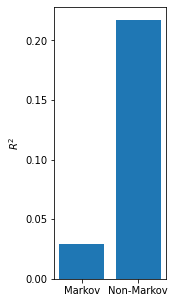

In [23]:
plt.figure(figsize=(2,5))
plt.bar(['Markov','Non-Markov'], [0.02885, 0.2171])
plt.ylabel('$R^2$')


### Ranking-based metrics

In [24]:
def hits_at_rank(Y_test, Y_pred):
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(Y_test)
    distances, indices = nbrs.kneighbors(Y_test)
    return np.mean(np.linalg.norm(Y_pred - Y_test, axis=1) < distances[:,-1])

hits_at_rank(Xdiff_test, Xdiff_pred)

0.914

### Interpreting output from convolution layers
We use 1-D convolutional layers to convolve over time. Now we visualise the output (activations) of these 1D convolutional layers.

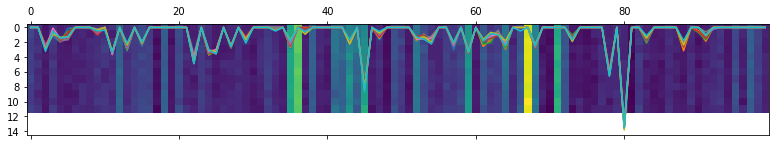

In [25]:
i = 250
Xwin_test[i].shape
plt.matshow(Xwin_test[i])
plt.plot(10*model_2.layers[0](Xwin_test[i:i+1])[0].numpy().T)

## Simulating data using the AR model

In [26]:
n_0 = 390 ### a number between win and Xwin_test[:,0,0].shape - win
n_steps = 50
Inp_t = Xwin_test[n_0-win]
X_test_sim = Xwin_test[n_0:n_0+n_steps, 0, :]
X_sim = np.zeros_like(X_test_sim)
for t, _  in enumerate(X_sim):
    X_diffpred = model_2(Inp_t[None,:,:])
    X_tp1 = Inp_t[-gap] + X_diffpred 
    X_sim[t] = X_tp1
    Inp_t = np.r_[Inp_t[1:], X_tp1]

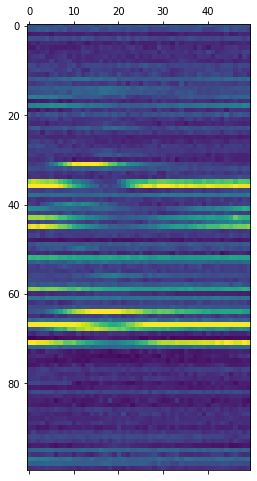

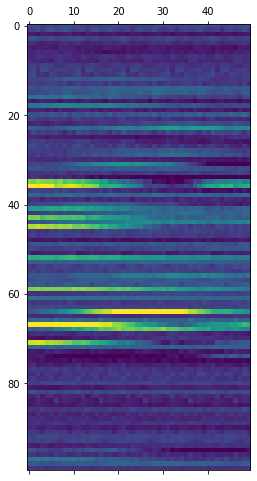

In [27]:
plt.matshow(X_test_sim.T,vmin=0, vmax=1)
plt.matshow(X_sim.T,vmin=0, vmax=1)


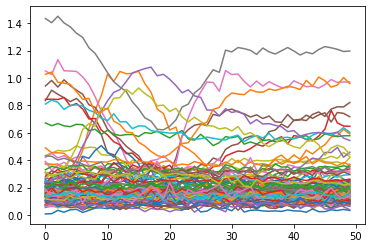

In [28]:
plt.plot(X_test_sim[:,])

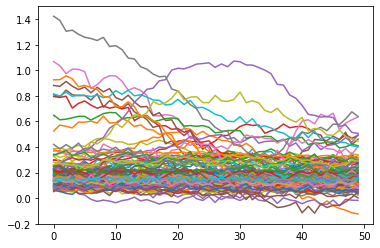

In [29]:
plt.plot(X_sim)
#plt.axis([0,300,-1,2])
